In [33]:
import pandas as pd
import numpy as np 
import pymc as pm
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msg
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import os, sys

import logging

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get the absolute path to the parent directory
parent_dir = os.path.dirname(os.getcwd())

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from src import handler

In [3]:
# Initialize the logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Data Gathering

In [4]:
def load_data(path):
    try:
        df = pd.read_csv(path, low_memory=False)
        return df
    except Exception as e:
        logger.info(f"Error on Loding Data {e}")

In [5]:
url = "../data/BrentOilPrices.csv"
brent_df = load_data(url)

In [6]:
brent_df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


# Data Overview

In [7]:
# create handler object
df1 = handler.Handler(brent_df)

In [8]:
# Data overview of brent_df
df1.data_overview()

Number of rows: 9011
Number of columns: 2

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
None


# Data Cleaning
- Handling missing values
- Handling duplicate values
- Handling outliers 

## 1. Handling Missing Values
Handling missing values is another important step in data cleaning. Missing values can be represented as NaN (Not a Number) or empty strings. I use the `isnull()` function to identify missing values and the `dropna()` function to remove rows with missing values.

In [9]:
# check missing values credit_df
df1.calculate_missing_percentage()

       Missing Values Percentage Missing
Date                0              0.00%
Price               0              0.00%


<Axes: >

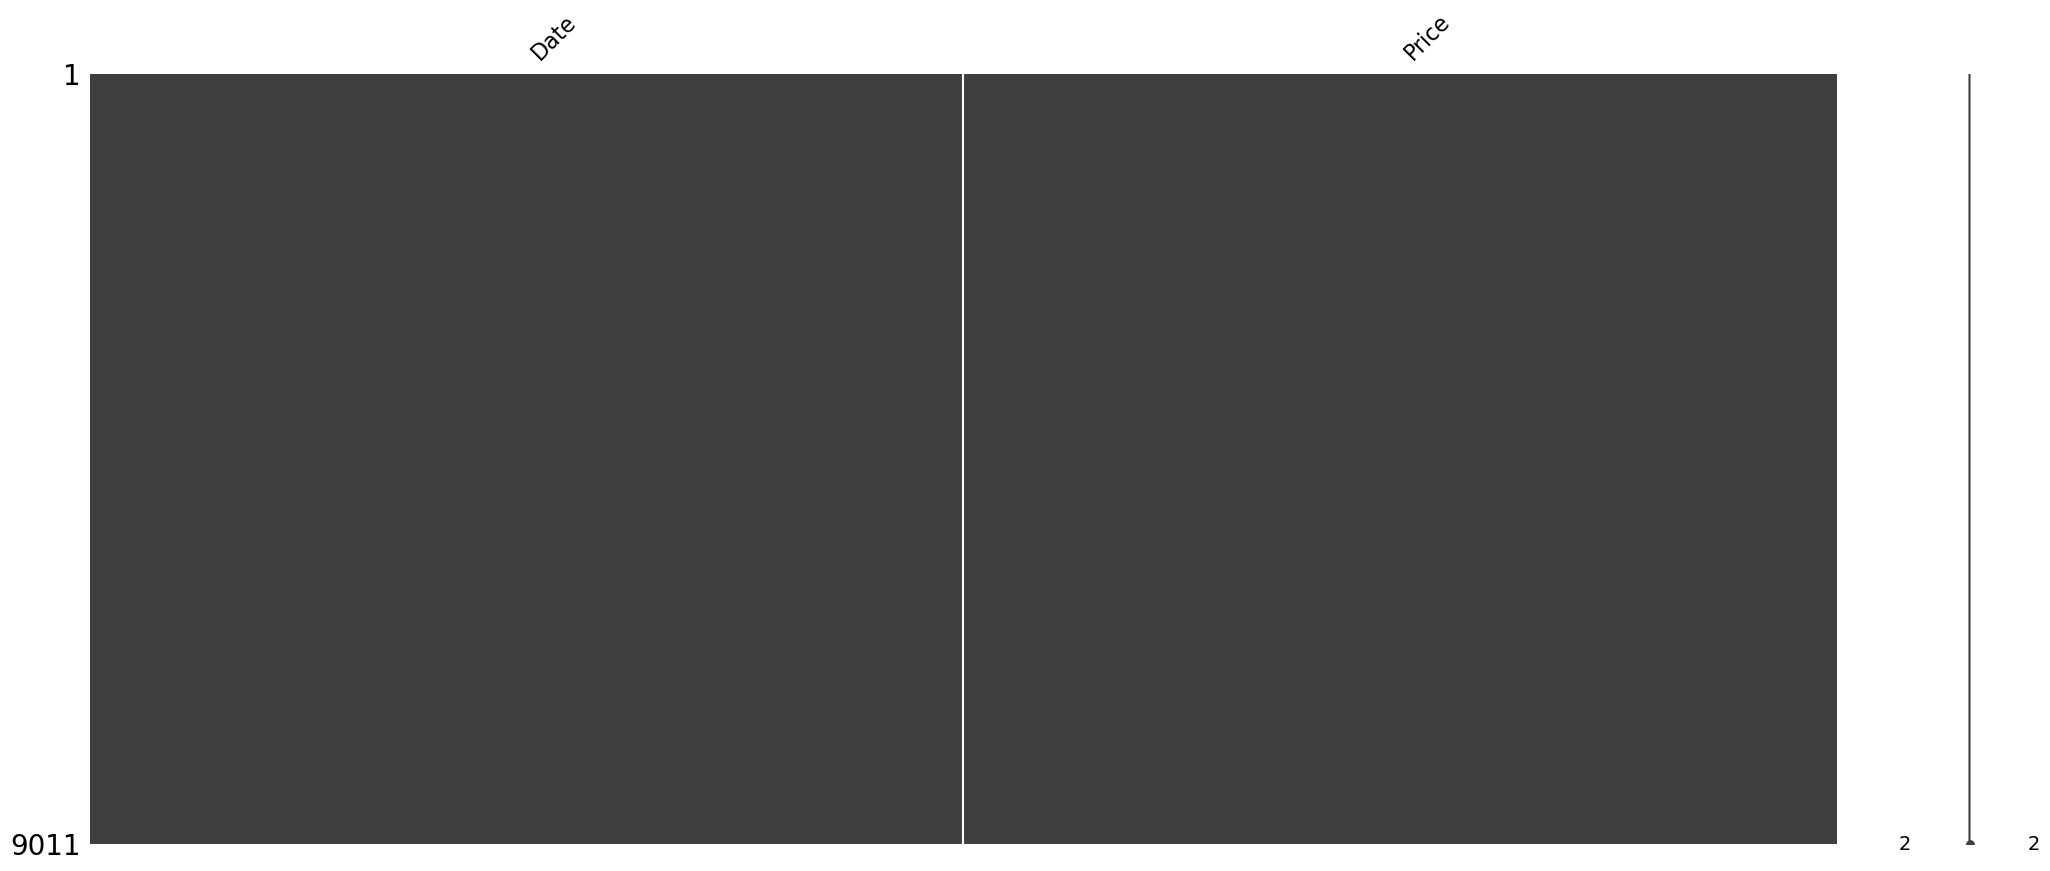

In [10]:
# visualize missing values
msg.matrix(brent_df)

## 2. Handling Duplicate Values
Handling duplicate values involves identifying and removing duplicate rows from the DataFrame. I use the `duplicated()` function to identify duplicate rows and the `drop_duplicates()` function to remove them.

In [11]:
#check duplicate values for brent_df
df1.check_duplicate()


Duplicated values:
0 duplicated rows


## 3. Handling outliers
Handling outliers is a crucial step in data cleaning and preprocessing. Here are the key steps to handle outliers effectively:
#### Identifying Outliers
The first step is to identify the presence of outliers in my dataset. I Use box plots.

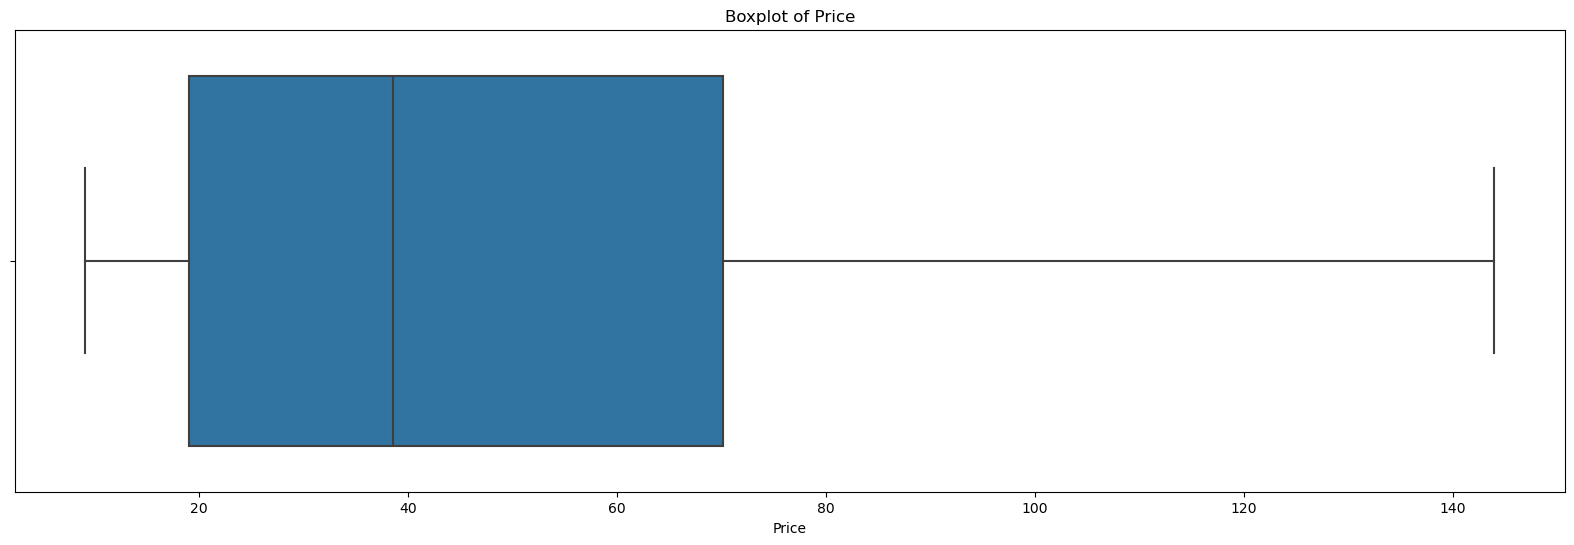

In [12]:
visualizer.plot_boxplot(brent_df, "Price")

The whisker of the above box plots shows that there is no outlier in the column.

# Preprocess the data

In [13]:
# Preprocess the data
brent_df['Date'] = pd.to_datetime(brent_df['Date'])
brent_df.set_index('Date', inplace=True)

# Descriptive Statistics

In [14]:
brent_df['Price'].describe()

count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64

# Exploratory Data Analysis (EDA)

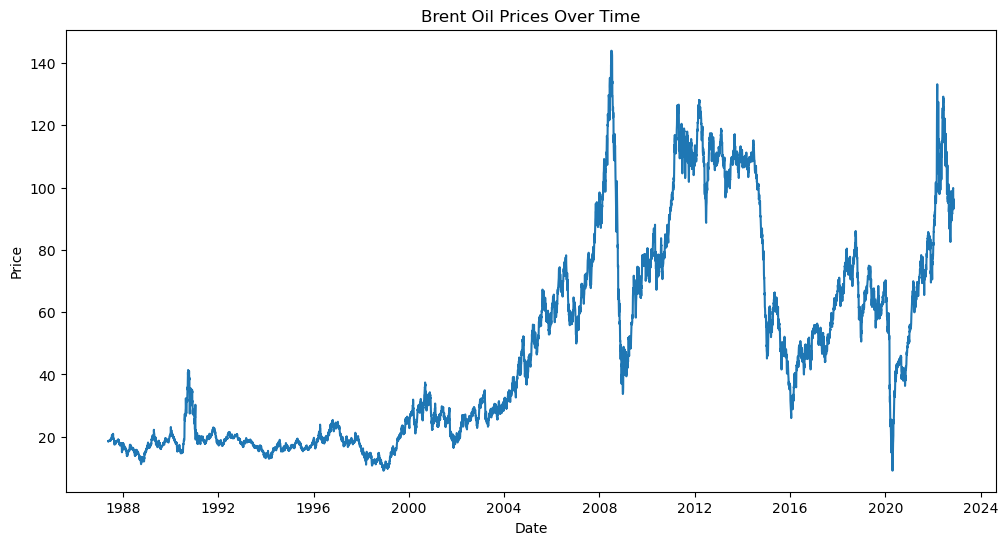

In [17]:
# Plot the data
def plot_line():
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=brent_df.index, y=brent_df['Price'])
    plt.title('Brent Oil Prices Over Time')
    plt.show()

plot_line()

This plot shows the historical prices of Brent oil from around 1987 to 2024. Key observations include:

- Volatility: There are significant fluctuations in oil prices over the period. Sharp increases around 2008, 2012, and 2022. Significant drops around 1998, 2008-2009, 2014-2015, and 2020.

- Trends: A general upward trend from the early 2000s to around 2008.
        Post-2008, prices show higher volatility but don't exhibit a clear upward or downward long-term trend.

- Recent Trends: Prices show a sharp increase around 2022, followed by a decline and some level of stabilization.

# Data Normalization

In [38]:
brent_df["Price"].var()

1079.7868260359899

In [39]:
brent_df["Price"] = np.log(brent_df["Price"])

In [40]:
brent_df["Price"].var()

0.5000217121510149

# Model Building with PyMC3

In [20]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal('mu', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=brent_df['Price'])

    # Inference
    trace = pm.sample(2000, tune=1000)

2024-07-07 21:01:38,576 - INFO - Compiling new CVM
2024-07-07 21:01:39,902 - INFO - New version 0.212
2024-07-07 21:01:58,670 - INFO - Auto-assigning NUTS sampler...
2024-07-07 21:01:58,917 - INFO - Initializing NUTS using jitter+adapt_diag...
2024-07-07 21:02:06,029 - INFO - Multiprocess sampling (2 chains in 2 jobs)
2024-07-07 21:02:06,030 - INFO - NUTS: [mu, sigma]


Output()

2024-07-07 21:02:15,214 - INFO - Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.
2024-07-07 21:02:21,117 - INFO - We recommend running at least 4 chains for robust computation of convergence diagnostics


In [35]:
# Summarize the trace
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,43.604,0.322,42.977,44.175,0.005,0.004,3985.0,3261.0,1.0
sigma,31.521,0.219,31.102,31.922,0.004,0.003,3786.0,2775.0,1.0


The above table data shows statistics for a Bayesian model, with two parameters: `mu` and `sigma`. Here's a brief analysis of the data:

1. **mu**: This typically represents the mean of the distribution.
   - The mean of `mu` is 43.604, which is the average value of the posterior distribution for `mu`.
   - The standard deviation (sd) of `mu` is 0.322, which gives us an idea of the spread of the posterior distribution.
   - The 94% highest density interval (HDI) ranges from 42.977 to 44.175. This means that there is a 94% probability that the true value of `mu` lies within this range.
   - The Monte Carlo standard error (mcse) for the mean and sd are quite low (0.005 and 0.004 respectively), indicating that the Monte Carlo approximation is quite accurate.
   - The effective sample size (ess) both for bulk and tail are quite high (3985.0 and 3261.0 respectively), which suggests that the MCMC (Markov Chain Monte Carlo) sampling was efficient and the samples are not highly autocorrelated.
   - The `r_hat` value is 1.0, which indicates good convergence of the MCMC chains.

2. **sigma**: This typically represents the standard deviation of the distribution.
   - The mean of `sigma` is 31.521, which is the average value of the posterior distribution for `sigma`.
   - The standard deviation (sd) of `sigma` is 0.219, which gives us an idea of the spread of the posterior distribution.
   - The 94% highest density interval (HDI) ranges from 31.102 to 31.922. This means that there is a 94% probability that the true value of `sigma` lies within this range.
   - The Monte Carlo standard error (mcse) for the mean and sd are quite low (0.004 and 0.003 respectively), indicating that the Monte Carlo approximation is quite accurate.
   - The effective sample size (ess) both for bulk and tail are quite high (3786.0 and 2775.0 respectively), which suggests that the MCMC sampling was efficient and the samples are not highly autocorrelated.
   - The `r_hat` value is 1.0, which indicates good convergence of the MCMC chains.

In summary, the model seems to have converged well (as indicated by `r_hat` values), and the posterior distributions for `mu` and `sigma` are quite narrow, suggesting that the estimates are quite precise.

# Model Evaluation

In [24]:
# Predict using the model
predictions = trace.posterior['mu'].mean(dim=("chain", "draw")).values

predictions = np.repeat(predictions, len(brent_df))

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(brent_df['Price'], predictions))
mae = mean_absolute_error(brent_df['Price'], predictions)
r2 = r2_score(brent_df['Price'], predictions)

print(f'RMSE: {rmse}, MAE: {mae}, R-squared: {r2}')

RMSE: 33.20941345123677, MAE: 27.62875245681152, R-squared: -0.021486389485419144


1. Root Mean Squared Error (RMSE)

    - Value: 33.209
    - Interpretation: RMSE measures the standard deviation of the residuals (prediction errors). It represents the average distance between the observed actual outcomes and the outcomes predicted by the model.
    - Context: In the context of Brent oil prices, an RMSE of 33.209 means that, on average, the predicted prices deviate from the actual prices by about 33.209 USD per barrel. This value seems relatively high given that Brent oil prices typically range between $20 and $150 per barrel, indicating that the model's predictions have significant errors.

2. Mean Absolute Error (MAE)

    Value: 27.629
    Interpretation: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It is the average over the test sample of the absolute differences between prediction and actual observation.
    Context: An MAE of 27.629 means that, on average, the model's predicted prices are off by about 27.629 USD per barrel. This is also quite high, suggesting that the model's accuracy is not optimal.

3. R-squared (Coefficient of Determination)

    - Value: -0.021
    - Interpretation: R-squared indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, with 1 indicating perfect prediction and 0 indicating that the model does not explain any of the variance.
    - Negative R-squared: A negative R-squared indicates that the model performs worse than a horizontal line (mean of the data). This suggests that the model does not fit the data well at all and that the predictions are very poor.Root Mean Squared Error (RMSE).

# Insight Generation

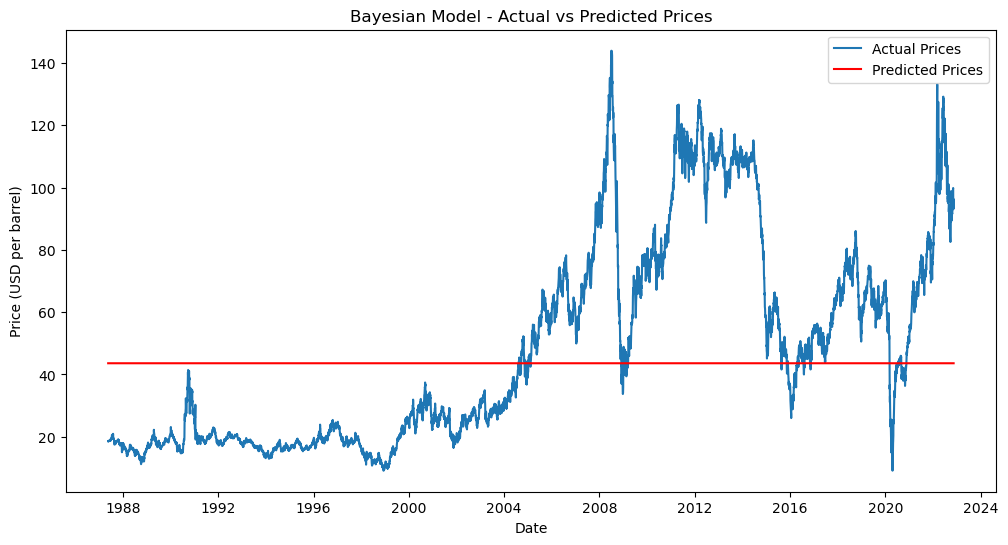

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(brent_df.index, brent_df['Price'], label='Actual Prices')
plt.plot(brent_df.index, predictions, label='Predicted Prices', color='red')
plt.title('Bayesian Model - Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()
plt.savefig('brent_oil_price_prediction.png')

This plot compares actual Brent oil prices with predictions made by a Bayesian model. Key points include:

- Predicted Prices: The predicted prices (red line) are constant at around 40 USD per barrel across the entire time period. This indicates that the model fails to capture the volatility and trends observed in the actual prices.

- Model Performance: The constant predicted value suggests that the model might be too simplistic or not appropriately tuned for this dataset. The actual prices show significant variance that the model does not capture, leading to high errors (RMSE, MAE) and poor R-squared values.

In [28]:
# Interpret the results
print("The model suggests that the average price of Brent oil is around:", np.mean(predictions))

# Example insight
if np.mean(predictions) > 60:
    print("Recommendation: Consider hedging strategies as oil prices are expected to remain high.")
else:
    print("Recommendation: Low oil prices may reduce input costs for industries reliant on oil.")

The model suggests that the average price of Brent oil is around: 43.60433704941875
Recommendation: Low oil prices may reduce input costs for industries reliant on oil.


# Communication of Results

In [32]:
# Generate a PDF report (example using a hypothetical function)
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Brent Oil Prices Analysis Report', 0, 1, 'C')
    
    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(10)
    
    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()
    
    def add_image(self, image_path):
        self.image(image_path, x=10, y=None, w=190)

pdf = PDF()
pdf.add_page()
pdf.chapter_title('Summary of Analysis')
pdf.chapter_body(f"RMSE: {rmse}\nMAE: {mae}\nR-squared: {r2}")
pdf.add_image('brent_oil_price_prediction.png')
pdf.output('brent_oil_price_analysis_report.pdf')

''

# Model Building with ARIMA

ARIMA RMSE: 55.76746241094648, MAE: 49.74473641483362, R-squared: -1.880526935395765


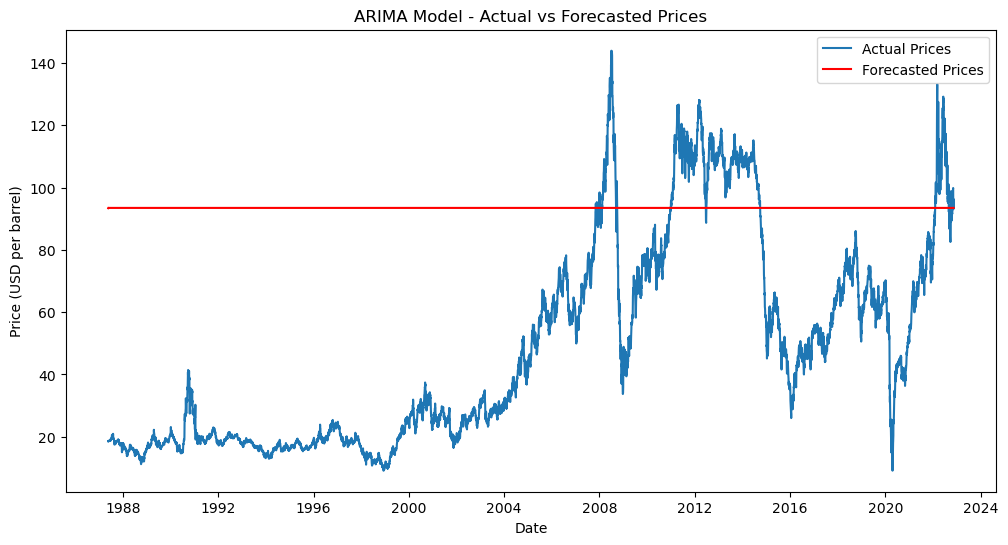

In [37]:
# Fit an ARIMA model
arima_model = ARIMA(brent_df['Price'], order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=len(brent_df))

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(brent_df['Price'], forecast))
mae = mean_absolute_error(brent_df['Price'], forecast)
r2 = r2_score(brent_df['Price'], forecast)

print(f'ARIMA RMSE: {rmse}, MAE: {mae}, R-squared: {r2}')

# Plot actual vs forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(brent_df.index, brent_df['Price'], label='Actual Prices')
plt.plot(brent_df.index, forecast, label='Forecasted Prices', color='red')
plt.title('ARIMA Model - Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

The plot displays the actual and forecasted prices of Brent oil using an ARIMA model. Here's a detailed analysis:

Analysis of the ARIMA Model Forecast

- Actual Prices:
        The blue line represents the historical actual prices of Brent oil in USD per barrel from around 1987 to 2024.
        The price shows significant fluctuations over time, with several peaks and troughs.
        Major spikes can be observed around 2008, 2012, and recently around 2022, indicating periods of high volatility in the oil market.

- Forecasted Prices:
        The red line represents the forecasted prices from the ARIMA model.
        The forecast appears to be a straight line, suggesting that the model might have predicted a constant mean value rather than capturing the time series dynamics accurately.